In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16
from torch.utils.data import DataLoader
from torchsummary import summary


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])


In [4]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
model = vgg16(weights='IMAGENET1K_V1')
model.classifier[6] = nn.Linear(4096, 10)  # Change the last layer to 10 classes for CIFAR-10
model = model.to(device)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.0MB/s]


In [6]:
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU

        optimizer.zero_grad()  # Reset gradients for each batch
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss

        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Accumulate loss

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get predictions
        total += labels.size(0)  # Update total number of labels
        correct += (predicted == labels).sum().item()  # Update correct predictions

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total  # Calculate accuracy

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


Epoch [1/10], Loss: 1.6140, Accuracy: 40.15%
Epoch [2/10], Loss: 1.1808, Accuracy: 57.70%
Epoch [3/10], Loss: 1.0454, Accuracy: 63.04%
Epoch [4/10], Loss: 0.9563, Accuracy: 66.23%
Epoch [5/10], Loss: 0.8836, Accuracy: 68.89%
Epoch [6/10], Loss: 0.8408, Accuracy: 70.64%
Epoch [7/10], Loss: 0.7895, Accuracy: 72.65%
Epoch [8/10], Loss: 0.7417, Accuracy: 74.29%
Epoch [9/10], Loss: 0.6984, Accuracy: 75.66%
Epoch [10/10], Loss: 0.6740, Accuracy: 76.62%


In [10]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 72.31%


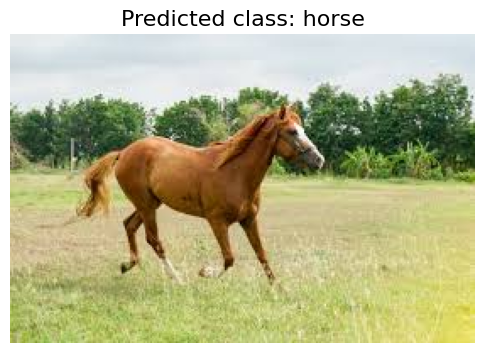

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

# Define the image preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load and preprocess the image
img_path = '/content/h-2.jpg'  # Path to the image
img = Image.open(img_path)  # Load the image
img_t = preprocess(img)  # Preprocess the image
batch_t = torch.unsqueeze(img_t, 0)  # Add a batch dimension
batch_t = batch_t.to(device)  # Move input to the same device as the model

# Perform inference
with torch.no_grad():  # Disable gradient calculation
    output = model(batch_t)  # Forward pass

# Get the predicted class
_, predicted = torch.max(output, 1)
class_idx = predicted.item()

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class = classes[class_idx]

# Display the image with the predicted class
plt.figure(figsize=(6, 6))
plt.imshow(img)  # Show the original image
plt.title(f'Predicted class: {predicted_class}', fontsize=16)
plt.axis('off')  # Hide axes
plt.show()
